In [2]:
from __future__ import print_function

import math

from pprint import pprint
from scipy import optimize, linalg

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio

/usr/local/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
data_male = np.genfromtxt('male100.csv',delimiter=',').T
data_female = np.genfromtxt('female100.csv',delimiter=',').T
data_male[0] = data_male[0] - 1900
data_female[0] = data_female[0] - 1900

# Maximum Likehood

Let's define some functions that will be used later on. In particula, we're interested in computing $\hat{\mathbf{w}}$ and $\hat{\sigma}^2$

In [4]:
def predict(x_new, model):
    return np.polynomial.polynomial.polyval(x_new, model)

def compute_design_matrix(x, n):
    return np.matrix([[(x_i)**k for k in range(n)] for x_i in x])

def train_w_hat(x, y, n=2):
    X = compute_design_matrix(x, n)#  np.matrix([[(x_i)**k for k in range(n)] for x_i in x])
    t = np.matrix(y).T
    return (X.T*X).I*X.T*t

def train_sigma2_hat(x, y, n=2):
    w_hat = train_w_hat(x, y, n)
    t = np.matrix(y).T
    X = compute_design_matrix(x, n)# np.matrix([[(x_i)**k for k in range(n)] for x_i in x])
    return ((t - X * w_hat).T * (t - X * w_hat) * (len(t)**-1)).ravel().tolist()[0][0]

## Question 3.1

In [5]:
for order in [2, 3, 4]:
    print('Male with order %d..: %f'% (order, train_sigma2_hat(data_male[0], data_male[1], n=order)))
    print('Female with order %d: %f'% (order, train_sigma2_hat(data_female[0], data_female[1], n=order)), end='\n\n')

Male with order 2..: 0.048549
Female with order 2: 0.047943

Male with order 3..: 0.038084
Female with order 3: 0.035169

Male with order 4..: 0.028599
Female with order 4: 0.034347



## Question 3.2

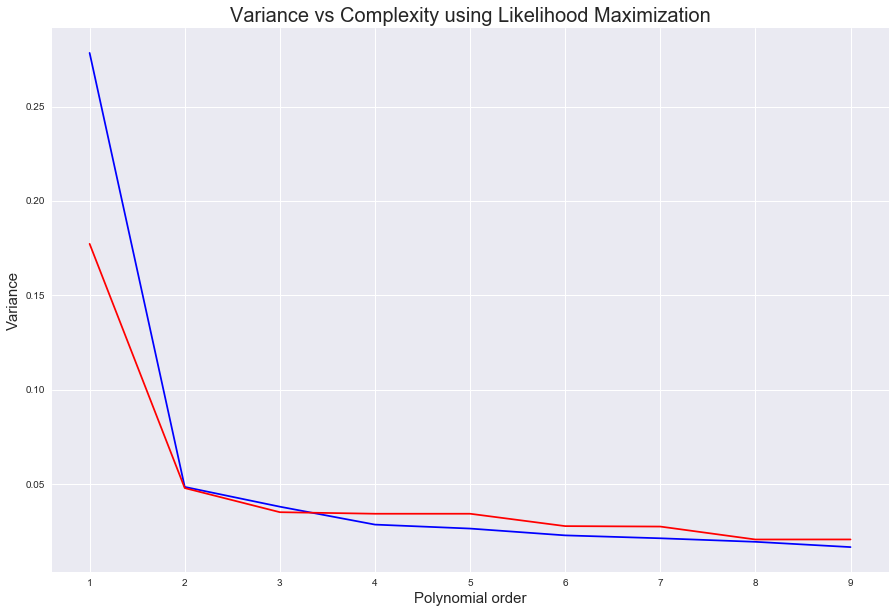

In [6]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

x = range(1,10)
y_male = [train_sigma2_hat(data_male[0], data_male[1], n=int(i)) for i in x]
y_female = [train_sigma2_hat(data_female[0], data_female[1], n=int(i)) for i in x]

#y_female = [math.log(LOO(data_female, complexity=int(i)).mean()) for i in x]


plt.plot(x, y_male, color='b',)
plt.plot(x, y_female, color='r',)
ax.set_xlabel('Polynomial order', fontsize=15)
ax.set_ylabel('Variance', fontsize=15)
plt.title('Variance vs Complexity using Likelihood Maximization', fontsize=20)
plt.show()

## Question 3.3

In [7]:
def LOO(dataset, complexity=2):
    errors = []
    variances = []
    list_indexes = list(range(0, len(dataset.T)))

    for i in list(range(len(list_indexes))):
        index_out = list_indexes.pop(0)
        data_LOO = dataset.T[list_indexes].T
        list_indexes.append(index_out)
        x_train = data_LOO[0] #- data_LOO[0][0]
        #pprint(x_train)
        t_train = data_LOO[1]
        x_test = dataset.T[index_out][0] #- data_LOO[0][0]
        t_test = dataset.T[index_out][1]
        
        model = [0, 0]
        model[0] = train_w_hat(x_train, t_train, n=complexity)
        model[1] = train_sigma2_hat(x_train, t_train, complexity)
        
        t_model = predict(x_test, model[0])
        #errors.append((x_test, ((t_test - t_model) ** 2)[0]))
        errors.append(((t_test - t_model) ** 2)[0])
        variances.append(model[1])
    return np.array(errors).mean(), np.array(variances).mean()

In [8]:
LOO(data_male, 3)

(0.056136278017371546, 0.037790155357667443)

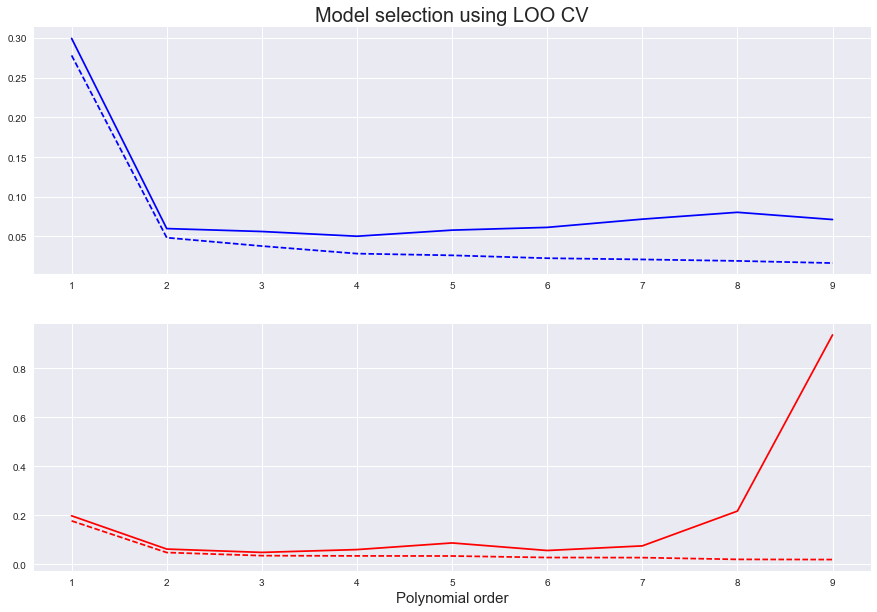

In [9]:
plt.figure(figsize=(15,10))

x = range(1,10)
y_male   = np.array([(LOO(data_male, complexity=int(i))) for i in x]).T
y_female = np.array([(LOO(data_female, complexity=int(i))) for i in x]).T

plt.subplot(211)

plt.plot(x, y_male[0], 'b',)
plt.plot(x, y_male[1], 'b--',)
#plt.xlabel('Polynomial order', fontsize=15)
plt.ylabel(u'', fontsize=15)
plt.title('Model selection using LOO CV', fontsize=20)

plt.subplot(212)

plt.plot(x, y_female[0], 'r',)
plt.plot(x, y_female[1], 'r--',)
plt.xlabel('Polynomial order', fontsize=15)
plt.ylabel(u' ', fontsize=15)
#plt.title('Model selection using LOO CV', fontsize=20)

#plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                    wspace=0.35)

plt.show()

# 4 Uncertainty in modeling

## Question 4.1 

In [10]:
def covariance_w_hat(dataset, order=2):
    sigma2 = train_sigma2_hat(x=dataset[0], y=dataset[1], n=order)
    X = compute_design_matrix(dataset[0], order) #np.matrix([[(x_i)**k for k in range(order)] for x_i in dataset[0]])
    return sigma2 * (X.T * X).I

In [11]:
covariance_w_hat(data_male)

matrix([[  5.68284464e-03,  -7.24576462e-05],
        [ -7.24576462e-05,   1.32949810e-06]])

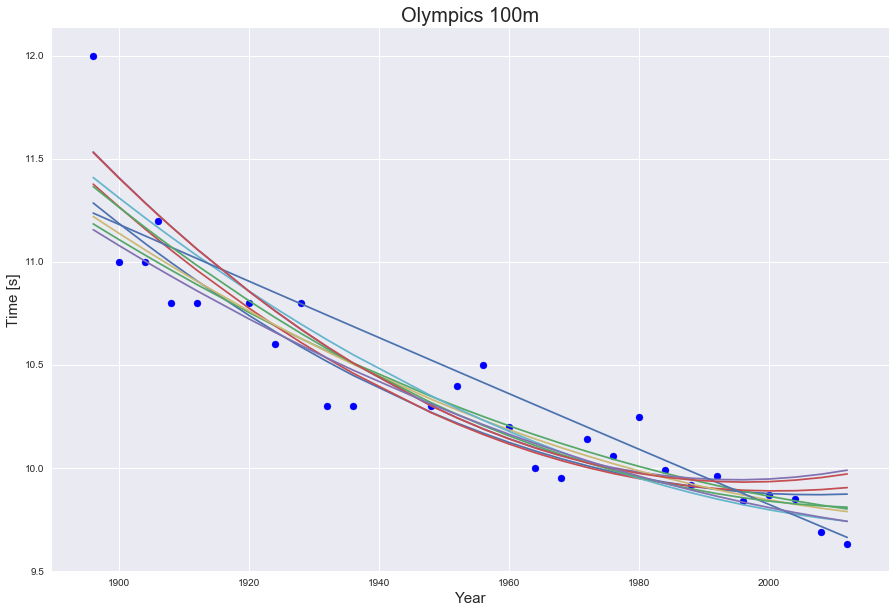

In [12]:
w_hat = train_w_hat(data_male[0], data_male[1], 3)
cov_w_hat = covariance_w_hat(data_male, 3)


w_samples = []
y_samples = []

plt.figure(figsize=(15,10))
plt.subplot(111)

for i in range(10):
    w_samples.append(np.matrix(np.random.multivariate_normal(np.array(w_hat).T[0], cov_w_hat)).T)
    y_samples.append([predict(x, w_samples[i])[0] for x in data_male[0]])
    plt.plot(data_male[0]+1900, y_samples[i])

plt.scatter(data_male[0]+1900, data_male[1], color='b')

plt.xlabel('Year', fontsize=15)
plt.ylabel('Time [s]', fontsize=15)
plt.title('Olympics 100m', fontsize=20)

plt.show()

## 5 Uncertainty in predictions

In [13]:
synthetic_mat = sio.loadmat('files_lab_lin_reg_bayes/synthetic_data.mat')
synthetic_dataset = [np.array(synthetic_mat['x']).T[0], np.array(synthetic_mat['t']).T[0]]

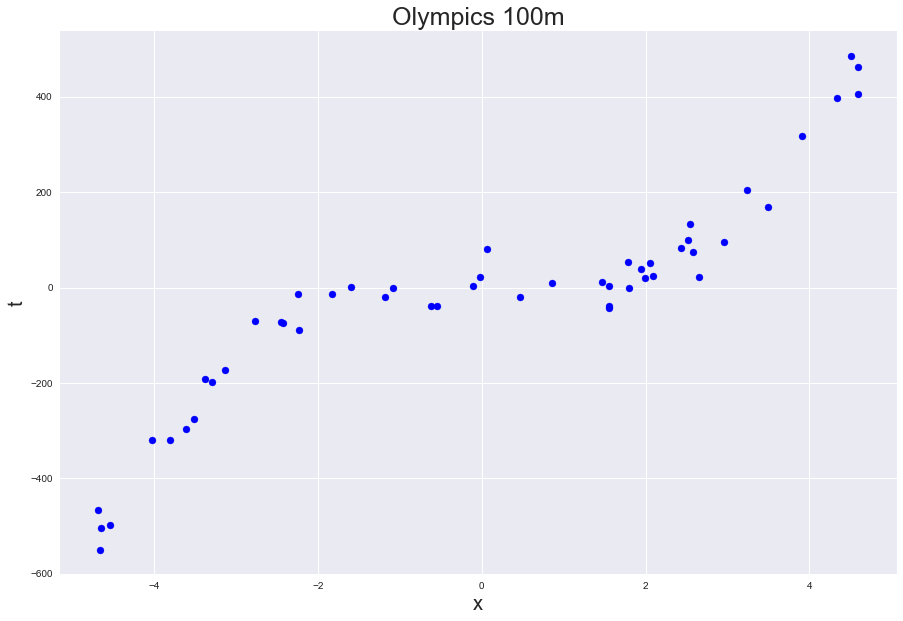

In [14]:
plt.figure(figsize=(15,10) )
plt.subplot(111)

plt.scatter(synthetic_dataset[0], synthetic_dataset[1], color='b')
plt.xlabel('x', fontsize=20)
plt.ylabel('t', fontsize=20)
plt.title('Olympics 100m', fontsize=25)

plt.show()

In [15]:
order = 3
synthetic_w_hat = train_w_hat(synthetic_dataset[0], synthetic_dataset[1], order)
synthetic_sigma2_hat = train_sigma2_hat(synthetic_dataset[0], synthetic_dataset[1], order)
synthetic_cov = covariance_w_hat(synthetic_dataset, order)

print(synthetic_w_hat, end='\n\n')
print(synthetic_sigma2_hat, end='\n\n')
print(synthetic_cov, end='\n\n')

[[-17.76572997]
 [ 70.27194623]
 [ -0.59031839]]

9953.18180116243

[[ 475.35931095  -12.04478994  -33.9887848 ]
 [ -12.04478994   24.99060355    1.40994809]
 [ -33.9887848     1.40994809    4.18137431]]



In [16]:
def predict_likelihood(x_new, w, cov_w):
    x_vect = np.matrix([x_new**k for k in range(len(w))]).T
    return (predict(x_new, w)[0], np.array(x_vect.T*cov_w*x_vect).tolist()[0][0])

In [17]:
predict_likelihood(np.array(2), synthetic_w_hat, synthetic_cov)

(120.41688891087385, 344.6934453451016)

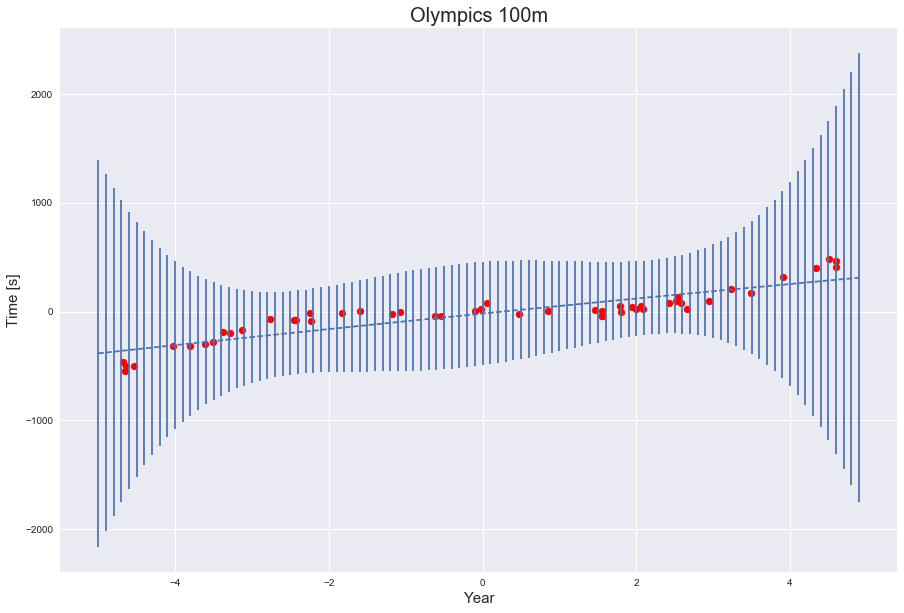

In [18]:
x_test = [i for i in np.arange(-5, 5, 0.1)]
y_test = np.array([predict_likelihood(i, synthetic_w_hat, synthetic_cov) for i in x_test]).T

plt.figure(figsize=(15,10))
plt.subplot(111)

plt.errorbar(x_test, y_test[0], yerr=y_test[1], fmt='--')
plt.scatter(synthetic_dataset[0], synthetic_dataset[1], color='r')

plt.xlabel('Year', fontsize=15)
plt.ylabel('Time [s]', fontsize=15)
plt.title('Olympics 100m', fontsize=20)

plt.show()